In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np


In [3]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
!pip install kaggle --quiet

!mkdir -p ~/.kaggle

from google.colab import files
uploaded = files.upload()

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d roobansappani/hand-gesture-recognition

!unzip -q hand-gesture-recognition.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/roobansappani/hand-gesture-recognition
License(s): copyright-authors
 89% 24.0M/27.1M [00:02<00:00, 18.7MB/s]
100% 27.1M/27.1M [00:02<00:00, 12.1MB/s]


In [5]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2 ,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [6]:
train_data = datagen.flow_from_directory(
    r'/content/HandGesture/images',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training')

val_data = datagen.flow_from_directory(
    r'/content/HandGesture/images',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation')


Found 4199 images belonging to 10 classes.
Found 1044 images belonging to 10 classes.


In [7]:
class_indices = train_data.class_indices
print(class_indices)
class_indices = train_data.class_indices
print("Class Indices:", class_indices)

class_labels = train_data.classes

{'call_me': 0, 'fingers_crossed': 1, 'okay': 2, 'paper': 3, 'peace': 4, 'rock': 5, 'rock_on': 6, 'scissor': 7, 'thumbs': 8, 'up': 9}
Class Indices: {'call_me': 0, 'fingers_crossed': 1, 'okay': 2, 'paper': 3, 'peace': 4, 'rock': 5, 'rock_on': 6, 'scissor': 7, 'thumbs': 8, 'up': 9}


In [8]:
class_counts = {class_name: np.sum(class_labels == class_index)
                for class_name, class_index in class_indices.items()}

In [9]:
print("Number of images in each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Number of images in each class:
call_me: 422 images
fingers_crossed: 404 images
okay: 432 images
paper: 432 images
peace: 421 images
rock: 407 images
rock_on: 425 images
scissor: 422 images
thumbs: 430 images
up: 404 images


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(12, activation='relu',)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dense(12, activation='relu',)(x)
x = Dense(len(class_indices), activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=x)

In [12]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()
tf.debugging.set_log_device_placement(True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1)

val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy:.2f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,055,706 (26.92 MB)

 Trainable params: 18,202 (71.10 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.1811 - loss: 2.1691 - val_accuracy: 0.4943 - val_loss: 1.4877
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 953ms/step - accuracy: 0.5530 - loss: 1.1906 - val_accuracy: 0.7893 - val_loss: 0.6276
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 965ms/step - accuracy: 0.8101 - loss: 0.5579 - val_accuracy: 0.8736 - val_loss: 0.4111
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8838 - loss: 0.3500 - val_accuracy: 0.8726 - val_loss: 0.3606
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 74s 959ms/step - accuracy: 0.9020 - loss: 0.2916 - val_accuracy: 0.8946 - val_loss: 0.3134
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9146 - loss: 0.2642 - val_accuracy: 0.8966 - val_loss: 0.2906
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 964ms/step - accuracy: 0.9246 - loss: 0.2251 - val_accuracy: 0.9138 - val_loss: 0.2426
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 69s 970ms/step - accuracy: 0.9340 - loss: 0.1996 - val_accuracy: 0.9080 - val_

In [13]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=2,
    verbose=1)



Epoch 1/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.7639 - loss: 0.8297 - val_accuracy: 0.8180 - val_loss: 0.7221
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9494 - loss: 0.1434 - val_accuracy: 0.7835 - val_loss: 1.0013


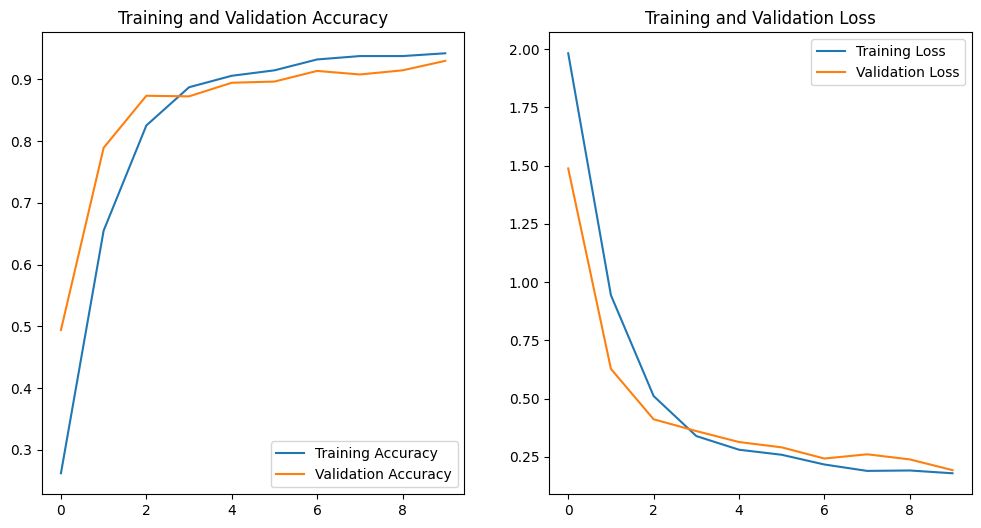

In [15]:

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


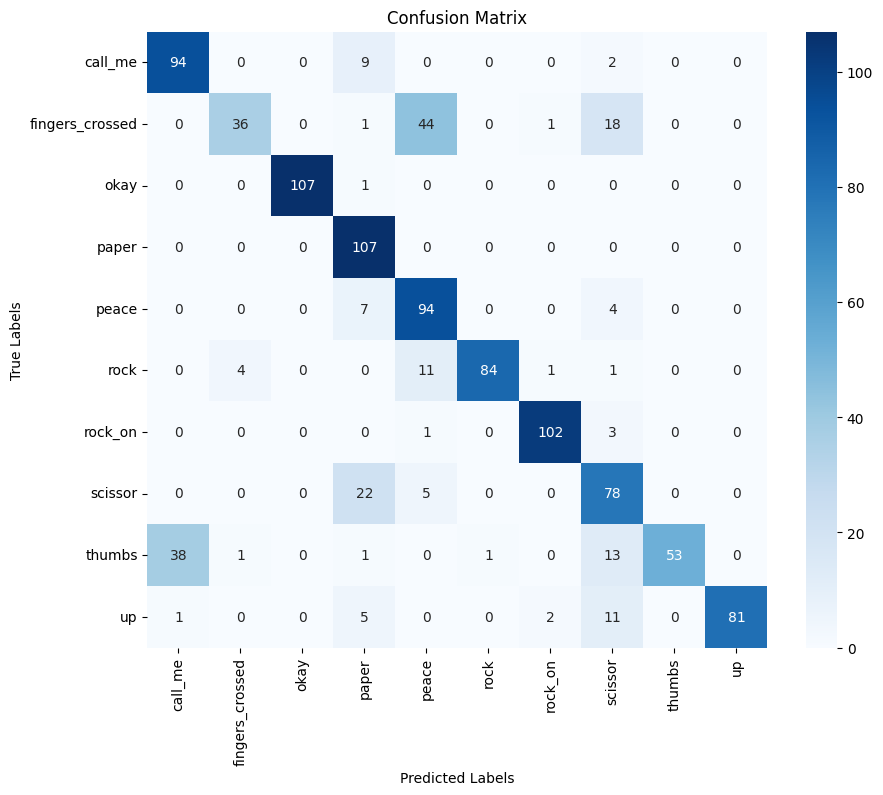

In [16]:

y_true = np.concatenate([val_data[i][1] for i in range(len(val_data))])
y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(model.predict(val_data), axis=1)


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [17]:

class_report = classification_report(y_true, y_pred, target_names=val_data.class_indices.keys())
print("Classification Report:\n", class_report)


Classification Report:
                  precision    recall  f1-score   support

        call_me       0.71      0.90      0.79       105
fingers_crossed       0.88      0.36      0.51       100
           okay       1.00      0.99      1.00       108
          paper       0.70      1.00      0.82       107
          peace       0.61      0.90      0.72       105
           rock       0.99      0.83      0.90       101
        rock_on       0.96      0.96      0.96       106
        scissor       0.60      0.74      0.66       105
         thumbs       1.00      0.50      0.66       107
             up       1.00      0.81      0.90       100

       accuracy                           0.80      1044
      macro avg       0.84      0.80      0.79      1044
   weighted avg       0.84      0.80      0.79      1044



17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 767ms/step
y_true_one_hot shape: (1044, 10)
y_pred_prob shape: (1044, 10)


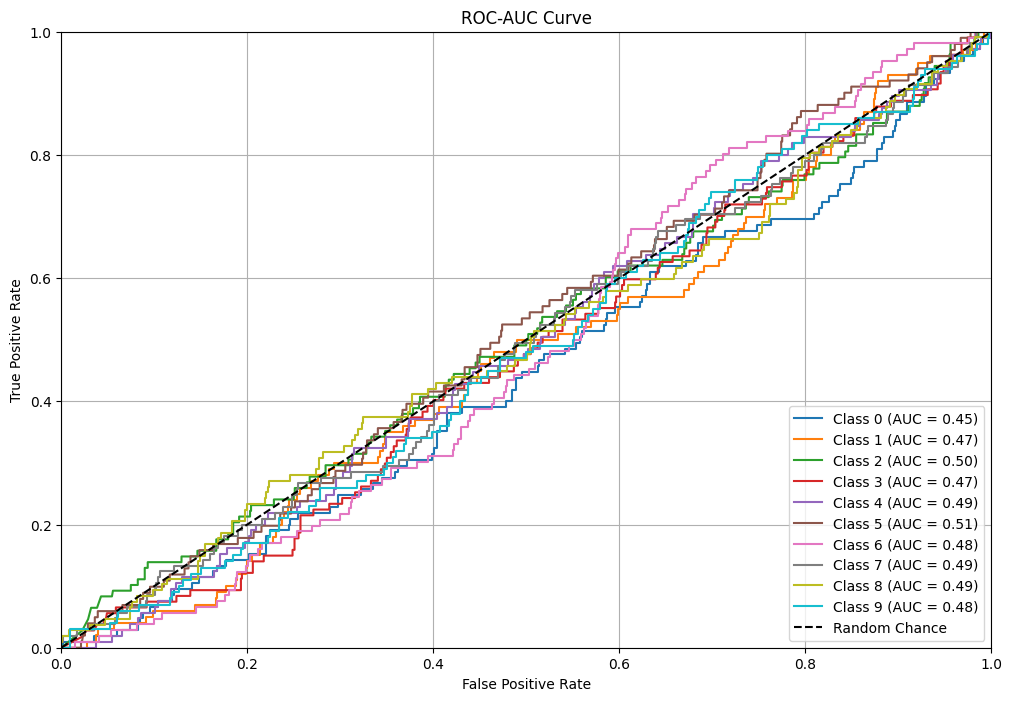

In [21]:

# Get true labels
y_true = val_data.classes  # Shape: (num_samples,)
n_classes = len(val_data.class_indices)

# One-hot encode the true labels
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

# Get predicted probabilities
y_pred_prob = model.predict(val_data)

# Check shapes
print("y_true_one_hot shape:", y_true_one_hot.shape)
print("y_pred_prob shape:", y_pred_prob.shape)

# Plot ROC-AUC curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()
